# Sleep staging on the Sleep Physionet dataset

## Sleep staging

Sleep staging is the process of identifying the sleep stage someone is in by analyzing their EEG and other physiological signals. Sleep recordings are traditionally divided into 30-s windows, and one of five categories ("stages") is attributed to each window:

1. W: wakefulness
2. N1: light sleep
3. N2: deeper sleep
4. N3: deep sleep
5. R: rapid eye movement

Sleep staging usually relies on capturing changes in the spectral properties of the EEG as well as transient events (e.g., sleep spindles, k-complexes, slow waves, etc.) that occur under the different sleep stages.

Thus, our objective is to create a Neural Network able to accurately classify the different sleep stages without the help of an expert. We will train a convolutional neural network (ConvNet) to perform sleep staging on unseen raw EEG. We will use the [Sleep Physionet](https://physionet.org/content/sleep-edfx/1.0.0/) dataset, which contains 153 overnight sleep recordings from 78 individuals. These recordings were manually staged by sleep experts, providing us with the required classification targets to train and evaluate our ConvNet on.

## Steps

This notebook is divided into the following sections:

0. [Set up environment](#0.-Setting-up-the-environment)
1. [Load data](#1.-Loading-data)
2. [Preprocess data (filter, window)](#2.-Preprocessing-raw-data)
    1. [Frequency filtering](#2.1.-Filtering)
    2. [Artifact Handling](#2.2.-Artifact-handling)
        1. [Automatic and Tunable Artifact Removal Algorithm (**ATAR**)](#2.2.1.-ATAR)
    3. [Extracting Epochs](#2.3.-Extracting-Epochs)
3. [Make splits](#3.-Making-train,-valid-and-test-splits)
4. [Convert the datasets as Pandas Dataframes](#4.-Dataset-to-Dataframe)
5. [Resampling the Data](#5.-Resampling-the-data)
6. [Detection of anomalies/outliers](#6.-Anomaly-detection)
7. [Visualizing the Data](#7.-Visualizing-the-Data)
8. [Data Augmentation](#8.-Data-Augmentation)
    1. [Brain Waves](#8.1.-Brain-Waves)
    2. [Pearson Cross Correlation Coefficient](#8.2.-Pearson-Cross-Correlation-Coefficient)
9. [Dataframe to Dataset](#9.-Dataframe-to-Dataset)
10. [Create model](#10.-Creating-the-neural-network)
11. [Train and monitor](#11.-Train-and-monitor-network)
12. [Visualize results](#12.-Visualizing-results)

## 0. Setting up the environment

In [1]:
%pip install torch  #should already be installed on colab

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#should'


In [2]:
# Identify whether a CUDA-enabled GPU is available
import torch

if torch.cuda.is_available():
    print('CUDA-enabled GPU found. Training should be faster.')
else:
    print('No GPU found. Training will be carried out on CPU, which might be '
          'slower.\n\nIf running on Google Colab, you can request a GPU runtime by'
          ' clicking\n`Runtime/Change runtime type` in the top bar menu, then '
          'selecting \'GPU\'\nunder \'Hardware accelerator\'.')

No GPU found. Training will be carried out on CPU, which might be slower.

If running on Google Colab, you can request a GPU runtime by clicking
`Runtime/Change runtime type` in the top bar menu, then selecting 'GPU'
under 'Hardware accelerator'.


In [3]:
# Install required packages for colab
%pip install mne
%pip install torch
%pip install matplotlib
%pip install scikit-learn
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\emman\appdata\local\programs\python\python311\lib\site-packages\eeglib-0.4-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\emman\appdata\local\programs\python\python311\lib\site-packages\fastdtw-0.3.4-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\emman\appdata\local\programs\python\python311\lib\site-packages\llvmlite-0.41.1-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\emman\appdata\local\programs\python\python311\lib\site-packages\eeglib-0.4-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\emman\appdata\local\programs\python\python311\lib\site-packages\fastdtw-0.3.4-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\emman\appdata\local\programs\python\python311\lib\site-packages\llvmlite-0.41.1-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\emman\appdata\local\programs\python\python311\lib\site-packages\eeglib-0.4-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\emman\appdata\local\programs\python\python311\lib\site-packages\fastdtw-0.3.4-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\emman\appdata\local\programs\python\python311\lib\site-packages\llvmlite-0.41.1-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\emman\appdata\local\programs\python\python311\lib\site-packages\eeglib-0.4-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\emman\appdata\local\programs\python\python311\lib\site-packages\fastdtw-0.3.4-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\emman\appdata\local\programs\python\python311\lib\site-packages\llvmlite-0.41.1-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\users\emman\appdata\local\programs\python\python311\lib\site-packages\eeglib-0.4-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\emman\appdata\local\programs\python\python311\lib\site-packages\fastdtw-0.3.4-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\emman\appdata\local\programs\python\python311\lib\site-packages\llvmlite-0.41.1-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\

In [4]:
# import general modules
import os
import copy

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## **Choosing the method**

This code is based on :
> Chambon, S., Galtier, M. N., Arnal, P. J., Wainrib, G., & Gramfort, A. (2018). A deep learning architecture for temporal sleep stage classification using multivariate and multimodal time series. IEEE Transactions on Neural Systems and Rehabilitation Engineering, 26(4), 758-769.

We implemented a few new different methods in order to improve the classification. To vizualize the impact of these methods here you can choose whether or not you want to apply them. The methods we implemented are :

1. Artifact handling using ATAR and/or Widrow filtering
2. Anomaly detection with Autoencoders
3. Resampling the data using different methods : SMOTE, ADASYN, random undersampling and oversampling...
4. Feature extraction for better performances
5. Generative Adversial Network to create new data to train the model

**In the cell below change the variable to True if you want to use this method**

If you want to resample the data (resampling==True), do not forget to specify the resampling method you wish to use.
For the ADASYN method you also need to choose undersampling or oversampling to be applied after because it does not give balanced classes


In [6]:
# Artifact handling
atar = False
# Choose between : "soft", "linAtten" and "elim"
optmode = "elim"
beta_value = 0.3

# Resampling the Data
resampling = False
# Choose from : "SMOTETomek", "ADASYN", "random_under_sampling", "random_over_sampling"
resampling_method = "SMOTETomek"
# for adasyn only (the sampling method that follows ADASYN because ADASYN alone does not give balanced classes)
# 0 --> undersampling
# 1 --> oversampling
follow_adasyn = 0

# Anomaly detection
anomaly_detection = False
percentage_of_anomalies = 1 # %

# Data augmentation
additional_features = False

## 1. Loading data

We start by loading the raw EEG recordings from the Sleep Physionet dataset. MNE-Python already contains a function `fetch_data` which downloads the recordings locally. We then need to read each file from the disk.

To make the first pass through this tutorial faster, we only load a part of the entire Sleep Physionet dataset (30 recordings out of 153). Once you are able to run the whole tutorial and are ready to work on improving the performance of the model, you can try loading more subjects and recordings.

In [7]:
import mne
from mne.datasets.sleep_physionet.age import fetch_data

mne.set_log_level('ERROR')  # To avoid flooding the cell outputs with messages

In [8]:
subjects = range(30)
recordings = [1]

# To load all subjects and recordings, uncomment the next line
# subjects, recordings = range(83), [1, 2]

In [9]:
fnames = fetch_data(subjects=subjects, recording=recordings, on_missing='warn')

""" Get paths to local copies of PhysioNet Polysomnography dataset files. This will fetch data from the publicly available
    subjects from PhysioNet's study of age effects on sleep in healthy subjects 12. This corresponds to a subset of
    153 recordings from 37 males and 41 females that were 25-101 years old at the time of the recordings.

Parameters
----------
subjects : list of int
    The subjects to use. Can be in the range of 0-82 (inclusive), however the following subjects are not available: 39, 68, 69, 78 and 79.

recording : list of int
    The night recording indices. Valid values are : [1], [2], or [1, 2].
    The following recordings are not available: recording 1 for subject 36 and 52, and recording 2 for subject 13.

path : None | str
    Location of where to look for the PhysioNet data storing location.
    If None, the environment variable or config parameter PHYSIONET_SLEEP_PATH is used.
    If it doesn't exist, the “~/mne_data” directory is used.
    If the Polysomnography dataset is not found under the given path, the data will be automatically downloaded to the specified folder.

on_missing : 'raise' | 'warn' | 'ignore'
    What to do if one or several recordings are not available. Valid keys are 'raise' | 'warn' | 'ignore'.
    Default is 'error'. If on_missing is 'warn' it will proceed but warn, if 'ignore' it will proceed silently.

Returns
-------
fnames : 
    list of paths to the .edf files  
"""


" Get paths to local copies of PhysioNet Polysomnography dataset files. This will fetch data from the publicly available\n    subjects from PhysioNet's study of age effects on sleep in healthy subjects 12. This corresponds to a subset of\n    153 recordings from 37 males and 41 females that were 25-101 years old at the time of the recordings.\n\nParameters\n----------\nsubjects : list of int\n    The subjects to use. Can be in the range of 0-82 (inclusive), however the following subjects are not available: 39, 68, 69, 78 and 79.\n\nrecording : list of int\n    The night recording indices. Valid values are : [1], [2], or [1, 2].\n    The following recordings are not available: recording 1 for subject 36 and 52, and recording 2 for subject 13.\n\npath : None | str\n    Location of where to look for the PhysioNet data storing location.\n    If None, the environment variable or config parameter PHYSIONET_SLEEP_PATH is used.\n    If it doesn't exist, the “~/mne_data” directory is used.\n   

In [10]:
def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True, 
                             crop_wake_mins=30):
    """Load a recording from the Sleep Physionet dataset.
    
    Parameters
    ----------
    raw_fname : str
        Path to the .edf file containing the raw data.
    annot_fname : str
        Path to the annotation file.
    load_eeg_only : bool
        If True, only keep EEG channels and discard other modalities 
        (speeds up loading).
    crop_wake_mins : float
        Number of minutes of wake events before and after sleep events.
    
    Returns
    -------
    mne.io.Raw :
        Raw object containing the EEG and annotations.        
    """
    mapping = {'EOG horizontal': 'eog',
               'Resp oro-nasal': 'misc',
               'EMG submental': 'misc',
               'Temp rectal': 'misc',
               'Event marker': 'misc'}
    exclude = mapping.keys() if load_eeg_only else ()
    
    raw = mne.io.read_raw_edf(raw_fname, exclude=exclude)
    annots = mne.read_annotations(annot_fname) 
    raw.set_annotations(annots, emit_warning=False)
    if not load_eeg_only:
        raw.set_channel_types(mapping)
    
    if crop_wake_mins > 0:  # Cut start and end Wake periods
        # Find first and last sleep stages
        mask = [x[-1] in ['1', '2', '3', '4', 'R'] 
                for x in annots.description]
        sleep_event_inds = np.where(mask)[0]

        # Crop raw
        tmin = annots[int(sleep_event_inds[0])]['onset'] - \
               crop_wake_mins * 60
        tmax = annots[int(sleep_event_inds[-1])]['onset'] + \
               crop_wake_mins * 60
        raw.crop(tmin=tmin, tmax=tmax)
    
    # Rename EEG channels
    ch_names = {i: i.replace('EEG ', '') 
                for i in raw.ch_names if 'EEG' in i}
    mne.rename_channels(raw.info, ch_names)
    
    # Save subject and recording information in raw.info
    basename = os.path.basename(raw_fname)
    subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
    raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb}
   
    return raw

In [11]:
# Load recordings
raws = [load_sleep_physionet_raw(f[0], f[1]) for f in fnames]

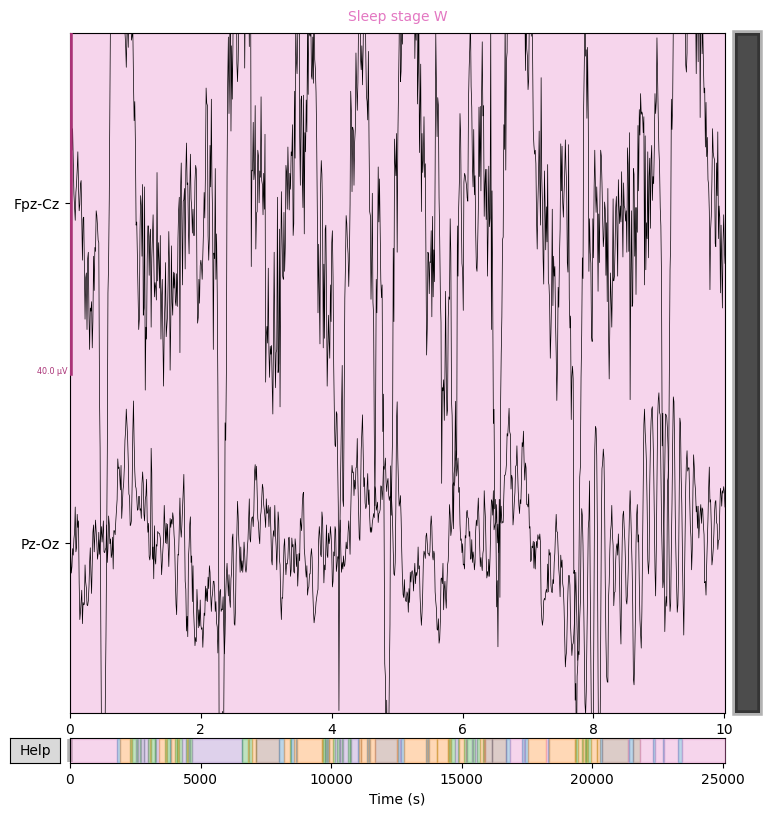

In [12]:
# Plot a recording as a sanity check
raws[0].plot();

## 2. Preprocessing raw data

Next, we need to preprocess the raw data. Here, we use a simple filtering step, followed by the deletion of artifacts and then extraction of 30-s windows.

### 2.1. Filtering

Sleep EEG data has most of its relevant information below 30 Hz. Therefore, to mitigate the impact of higher frequency noise, we apply a lowpass filter with cutoff frequency of 30 Hz to our recordings.

In [13]:
l_freq, h_freq = None, 30

for raw in raws:
    raw.load_data().filter(l_freq, h_freq)  # filtering happens in-place

Plot power or amplitude spectrum. Separate plots are drawn for each channel type. When the data have been processed with a bandpass, lowpass or highpass filter, dashed lines (╎) indicate the boundaries of the filter. The line noise frequency is also indicated with a dashed line (⋮). If average=False, the plot will be interactive, and click-dragging on the spectrum will generate a scalp topography plot for the chosen frequency range in a new figure.

c:\Users\emman\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:161: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


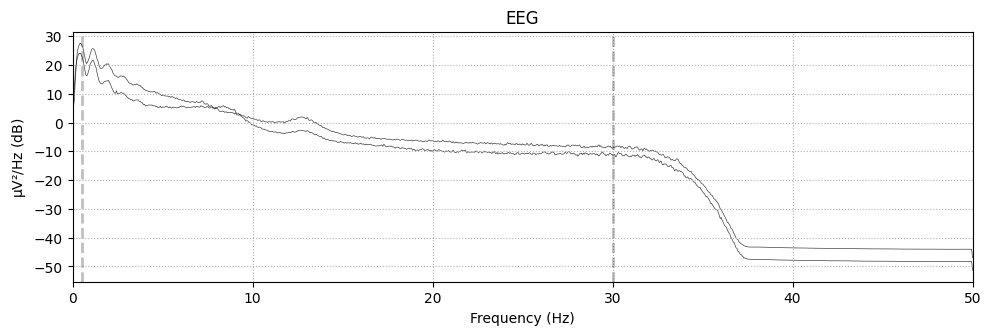

In [14]:
# Plot the power spectrum of a recording as sanity check
raws[0].plot_psd();

From the power spectral density plot, we can see that our filter has indeed cut off most of the power above 30 Hz.

### 2.2. Artifact Handling

Artifacts in EEG signals are disturbances or interferences that are not related to brain electrical activity but can be induced by various sources. The removal and management of these artifacts are crucial for obtaining high-quality EEG recordings and for interpreting the data accurately. We will try different methods that will be hopefully added in the future but for now let's focus on the Automatic and Tunable Artifact Removal Algorithm known as **ATAR**

#### 2.2.1. ATAR

In [15]:
%pip install spkit
import spkit as sp
sp.__version__

DEPRECATION: Loading egg at c:\users\emman\appdata\local\programs\python\python311\lib\site-packages\eeglib-0.4-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\emman\appdata\local\programs\python\python311\lib\site-packages\fastdtw-0.3.4-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\emman\appdata\local\programs\python\python311\lib\site-packages\llvmlite-0.41.1-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at c:\users\

'0.0.9.6'

In [16]:
def atar_artifact(raw, mode=optmode, beta=0.01, wavelet='db8') :
    """Apply the Adaptive Thresholding for Artifact Rejection (ATAR) method to remove artifacts from EEG data
    
    Parameters
    ----------
    raw : mne.io.Raw
        Raw EEG data in MNE format
    optmode : str, optional
        Optimization mode for ATAR ('soft' or 'hard', default is 'soft')
    beta : float, optional
        Parameter controlling the trade-off between sensitivity and specificity in ATAR (default is 0.01)
    wavelet : str, optional
        Wavelet function to be used in ATAR (default is 'db8')
    Returns
    -------
    mne.io.Raw
        Raw EEG data after applying the ATAR artifact removal method
    """
    for i in range(len(raw.info['ch_names'])) :
        X = raw.get_data(raw.info['ch_names'][i])
        X_atar =  sp.eeg.ATAR(X.ravel(), beta=beta, OptMode=mode, wv=wavelet, verbose=0,)
        raw._data[i, :] = X_atar
        
    return raw

In [17]:
import time # use of timer to monitor the function

if atar == True :
    for i, raw in enumerate(raws) :
        start_time = time.time()
        raws[i] = atar_artifact(raw, beta=beta_value)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"Itération {i+1}: Temps écoulé {elapsed_time} secondes")

### 2.3. Extracting Epochs

Before proceeding to extracting 30-s windows (also called *epochs*) from the filtered data, we define a few functions that we will need:

The function extract_epochs returns all epochs as a 3D array using the built-in method epochs.get_data and the number of the events associated with each epoch with epochs.events[:, 2] - 1 (from 0 to 4 instead of 1 to 5).
Let's have a look at all the different functions that are used here :

**<u>mne.events_from_annotations(`raw`, `event_id='auto'`)</u>** : Get <font color='blue'>events</font> and <font color='blue'>`event_id`</font> from an Annotations object.

**raw : *instance of `Raw`*** --> The raw data for which Annotations are defined.

**event_id : *`dict`* | *`callable()`* | *`None`* | *`auto`*** 
Can be :

* **dict** : map descriptions (keys) to integer event codes (values). Only the descriptions present will be mapped, others will be ignored.

* **callable** : must take a string input and return an integer event code, or return `None` to ignore the event.

* None: Map descriptions to unique integer values based on their sorted order.

* **‘auto’ (default)** : prefer a raw-format-specific parser:

    * Brainvision: map stimulus events to their integer part; response events to integer part + 1000; optic events to integer part + 2000; ‘SyncStatus/Sync On’ to 99998; ‘New Segment/’ to 99999; all others like `None` with an offset of 10000.

    * Other raw formats: Behaves like None.

**<u>mne.pick_types(*info, eeg, eog*)</u>** : Pick channels by type and names.

**info : *`mne.Info`*** : The **`mne.Info`** object with information about the sensors and methods of measurement.

**eeg : *`bool`*** : If True include EEG channels.

**eog : *`bool`*** : If True include EOG channels.

**<u>epochs.get_data()</u>** : Get all epochs as a 3D array.

In [18]:
def extract_epochs(raw, chunk_duration=30.):
    """Extract non-overlapping epochs from raw data.
    
    Parameters
    ----------
    raw : mne.io.Raw
        Raw data object to be windowed.
    chunk_duration : float
        Length of a window.
    
    Returns
    -------
    np.ndarray
        Epoched data, of shape (n_epochs, n_channels, n_times).
    np.ndarray
        Event identifiers for each epoch, shape (n_epochs,).
    """
    annotation_desc_2_event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3': 4,
        'Sleep stage 4': 4,
        'Sleep stage R': 5}

    events, _ = mne.events_from_annotations(
        raw, event_id=annotation_desc_2_event_id, 
        chunk_duration=chunk_duration)

    # create a new event_id that unifies stages 3 and 4
    event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3/4': 4,
        'Sleep stage R': 5}

    tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
    picks = mne.pick_types(raw.info, eeg=True, eog=True)
    epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                        event_id=event_id, tmin=0., tmax=tmax, baseline=None)
    
    return epochs.get_data(), epochs.events[:, 2] - 1

In [19]:
from torch.utils.data import Dataset, ConcatDataset


class EpochsDataset(Dataset):
    """Class to expose an MNE Epochs object as PyTorch dataset.
    
    Parameters
    ----------
    epochs_data : np.ndarray
        The epochs data, shape (n_epochs, n_channels, n_times).
    epochs_labels : np.ndarray
        The epochs labels, shape (n_epochs,)
    subj_nb: None | int
        Subject number.
    rec_nb: None | int
        Recording number.
    transform : callable | None
        The function to eventually apply to each epoch
        for preprocessing (e.g. scaling). Defaults to None.
    """
    def __init__(self, epochs_data, epochs_labels, subj_nb=None, 
                 rec_nb=None, transform=None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X[None, ...])
        return X, y
    

def scale(X):
    """Standard scaling of data along the last dimension.
    
    Parameters
    ----------
    X : array, shape (n_channels, n_times)
        The input signals.
        
    Returns
    -------
    X_t : array, shape (n_channels, n_times)
        The scaled signals.
    """
    X -= np.mean(X, axis=1, keepdims=True)
    return X / np.std(X, axis=1, keepdims=True)

We can now extract windows from each recording, and wrap them into Pytorch datasets.

In [20]:
# Apply windowing and move to pytorch dataset
all_datasets = [EpochsDataset(*extract_epochs(raw), subj_nb=raw.info['subject_info']['id'], 
                              rec_nb=raw.info['subject_info']['rec_id'], transform=scale) 
                for raw in raws]

# Concatenate into a single dataset
dataset = ConcatDataset(all_datasets)

You might have noticed we added a scaling transform to the datasets. This scaling makes sure each EEG channel in each 30-s window has a mean of 0 and a standard deviation of 1. This will help the neural network when training.

## 3. Making train, valid and test splits

Now that we have our preprocessed and windowed data, we can split it into the different sets that we will need: (1) the **training set** is used to learn the parameters of our ConvNet, (2) the **validation set** is used to monitor the training process and decide when to stop it, and (3) the **test set** is used to provide an estimate of the generalization performance of our model.

Here, we keep recording 1 of subjects 0-9 for testing, and split the remaining recordings into training and validation sets.

We define the following functions to perform the split:

In [21]:
from sklearn.model_selection import LeavePGroupsOut


def pick_recordings(dataset, subj_rec_nbs):
    """Pick recordings using subject and recording numbers.
    
    Parameters
    ----------
    dataset : ConcatDataset
        The dataset to pick recordings from.        
    subj_rec_nbs : list of tuples
        List of pairs (subj_nb, rec_nb) to use in split.
        
    Returns
    -------
    ConcatDataset
        The picked recordings.
    ConcatDataset | None
        The remaining recordings. None if all recordings from 
        `dataset` were picked.
    """
    pick_idx = list()
    for subj_nb, rec_nb in subj_rec_nbs:
        for i, ds in enumerate(dataset.datasets):
            if (ds.subj_nb == subj_nb) and (ds.rec_nb == rec_nb):
                pick_idx.append(i)
                
    remaining_idx = np.setdiff1d(
        range(len(dataset.datasets)), pick_idx)

    pick_ds = ConcatDataset([dataset.datasets[i] for i in pick_idx])
    if len(remaining_idx) > 0:
        remaining_ds = ConcatDataset(
            [dataset.datasets[i] for i in remaining_idx])
    else:
        remaining_ds = None
    
    return pick_ds, remaining_ds
    

def train_test_split(dataset, n_groups, split_by='subj_nb'):
    """Split dataset into train and test keeping n_groups out in test.
    
    Parameters
    ----------
    dataset : ConcatDataset
        The dataset to split.
    n_groups : int
        The number of groups to leave out.
    split_by : 'subj_nb' | 'rec_nb'
        Property to use to split dataset.
        
    Returns
    -------
    ConcatDataset
        The training data.
    ConcatDataset
        The testing data.
    """
    groups = [getattr(ds, split_by) for ds in dataset.datasets]
    train_idx, test_idx = next(
        LeavePGroupsOut(n_groups).split(X=groups, groups=groups))

    train_ds = ConcatDataset([dataset.datasets[i] for i in train_idx])
    test_ds = ConcatDataset([dataset.datasets[i] for i in test_idx])
        
    return train_ds, test_ds

In [22]:
# We seed the random number generators to make our splits reproducible
torch.manual_seed(87)
np.random.seed(87)

In [23]:
# Use recording 1 of subjects 0-9 as test set
test_recs = [(subj_nb, rec_nb)  # DO NOT CHANGE! This is a fixed set.
             for subj_nb, rec_nb in zip(range(10), [1] * 10)]
test_ds, train_ds = pick_recordings(dataset, test_recs)

In [24]:
# Split remaining recordings into training and validation sets
n_subjects_valid = max(1, int(len(train_ds.datasets) * 0.2))
train_ds, valid_ds = train_test_split(train_ds, n_subjects_valid, split_by='subj_nb')

print('Number of examples in each set:')
print(f'Training: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

Number of examples in each set:
Training: 18545
Validation: 4094
Test: 9850


## 4. Dataset to Dataframe

**Now we need to convert the ConcatDataset into a Pandas.Dataframe in order to work with it.**

The function `ConcatDataset_to_Dataframe` does this for us and gives us a dataframe with all the epochs and their label, not sorted. If we want to have multiple dataframe based on the label of the epoch (the 'label' column of each dataframe will have the same value for all rows), we can use the function `DataFrame_to_Dictionnary` which gives us a dictionnary with a nulber of elements equivalent the the number of conditions (label) or sleep stages in our case.

In [25]:
def ConcatDataset_to_Dataframe(concatdataset) :
    """Converts a ConcatDataset into a pandas.DataFrame
    
    Parameters
    ----------
    concatdataset : ConcatDataset
        ConcatDataset from which to retrieve the data
    Returns
    -------
    df : pandas.DataFrame
        DataFrame with 3 columns (['data'], ['label'], ['dataset_idx'])
        and number of rows = number of datasets in concatdataset
    """
    # We create a list of datasets using the concatdataset
    dataset_list = []
    for i in range(len(concatdataset.datasets)) :
        dataset_list.append(concatdataset.datasets[i])

    # Creating an empty list to store the data
    data_list = []
    # We iterate through the datasets, collecting the data and labels into the data_list
    for dataset_idx in range(len(dataset_list)) :
        for j in range(len(dataset_list[dataset_idx])) :
            # Data and label of the dataset's element
            data_tensor  = dataset_list[dataset_idx][j][0][0]
            label = dataset_list[dataset_idx][j][1]
            # We convert the tensor (Dataset[dataset_idx][0]) and the label (Dataset[dataset_idx][1]) into np.array
            data_array = data_tensor.numpy()

            # we append everything to the data_list
            data_list.append((data_array, label, dataset_idx))

    # We create a pandas DataFrame from the list of tuples (data, label, dataset_idx).
    df = pd.DataFrame(data_list, columns=["data", "label", "dataset_idx"])

    return df

**Converting the train dataset into a dataframe**

In [26]:
df_train = ConcatDataset_to_Dataframe(train_ds)
df_train.head() #to check

,data,label,dataset_idx
0,"[[-0.9975127359087527, -1.7442945067201923, -1...",0,0
1,"[[1.5670988153508976, 1.3290507034414052, 1.46...",0,0
2,"[[0.6677691542377409, 0.5146104720332021, 0.04...",0,0
3,"[[-0.06052764178749529, -0.3680642222464368, -...",0,0
4,"[[0.7691793683725097, 0.911729474285143, 0.915...",0,0


## 5. Resampling the data

We notice that the classes are imbalanced, i.e., there are a lot more of some classes than others. N2, especially, is more prevalent than the other sleep stages during the night:

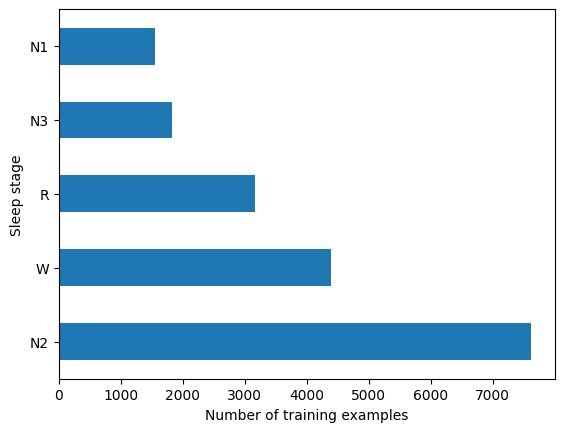

In [27]:
classes_mapping = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'R'}
y_train = pd.Series([y for _, y in train_ds]).map(classes_mapping)
ax = y_train.value_counts().plot(kind='barh')
ax.set_xlabel('Number of training examples');
ax.set_ylabel('Sleep stage');

One way to account for this imbalance during training is to give more weight to examples from rarer classes when computing the loss but since it is not the most efficient method we will try and implment some new ones.

The function `sampling_for_imbalanced_data` is designed to achieve this. You can choose between different method to do so

(We will leave the weights calculation after the resampling part to check if everything went well)

In [28]:
import seaborn as sns
from imblearn.combine import SMOTETomek


def count_occurences(dataframe, column_name) :
    """Count the occurrences of each element in the specified column
    
    Parameters
    ----------
    dataframe : pandas.DataFrame
        DataFrame from which occurrences are counted
    column_name : str
        Name of the column for which occurrences are counted
        Example: 'label'
    Returns
    -------
    count : dict
        Dictionary containing the names of elements in column_name and their occurrences
    """
    counts = dataframe[column_name].value_counts().to_dict()
    
    return counts


def DataFrame_to_Dictionnary(dataframe, mapping) :
    """Converts a DataFrame into a Dictionary of DataFrames
    The DataFrames are separated based on their labels
    
    Parameters
    ----------
    dataframe : pandas.DataFrame
        DataFrame to be split and organized into the dictionary
    mapping : dict
        Dictionary used to map each number in the 'label' column
        of the DataFrame to a corresponding letter
        Example sleep stage: mapping = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'R'}
    Returns
    -------
    dataframes_by_label_letter : dict
        Dictionary containing multiple DataFrames organized under different keys
        Each 'label' column in the DataFrames has a unique value given by the dictionary key
    """
    grouped = dataframe.groupby("label")

    # We create a list of individual DataFrames
    dataframes_by_label = []

    # We iterate through the different groups and add the new DataFrames to our list
    for label, group in grouped:
        dataframes_by_label.append(group.copy())
    
    dataframes_by_label_letter = {}
    # We iterate through the DataFrames and assign keys to them based on the mapping dictionary
    for df_temp in (dataframes_by_label):
        df_temp = df_temp.reset_index(drop=True)
        label = list(set(df_temp['label']))[0]  # Obtaining the unique label from the DataFrame
        lettre_label = mapping[label]
        cle_dictionnaire = f"Condition_{lettre_label}"
        dataframes_by_label_letter[cle_dictionnaire] = df_temp
        
    return dataframes_by_label_letter


def sampling_for_imbalanced_data(df, methode, mapping):
    """Sample unbalanced data to improve NN training
    
    Parameters
    ----------
    dataframe : pandas.DataFrame
        DataFrame from which we want to sample and balance the data
    method : str
        name of the method we want to use to balance the data
    mapping : dict
        Dictionary used to map the labels in the dataframe to a specific letter
    Returns
    -------
    pandas.DataFrame
        DataFrame containing an equal number of occurrences for each 'label'
    """
    # Appliquer la fonction pour aplatir chaque élément de la colonne "data"
    df = df.reset_index(drop=True)
    
    if methode == "random_under_sampling" :
        df_new = []
        # On regarde quel est la condition qui possède le moins de valeurs (clé du dictionnaire)
        min_value_key = min(count_occurences(df, 'label'), key=count_occurences(df, 'label').get)
        # On regarde quelle est cette valeur
        min_value = count_occurences(df, 'label')[min_value_key]
        min_value_key = mapping.get(min_value_key, "cette valeur n'est pas dans le dictionnaire")
        # Nouveau dictionnaire des conditions sans celle dont on se sert pour undersampler
        # Copie du dictionnaire original
        new_mapping = mapping.copy()
        # Valeur à supprimer
        value_to_remove = min_value_key

        # Recherche de la clé correspondante
        key_to_remove = None
        for key, value in new_mapping.items() :
            if value == value_to_remove:
                key_to_remove = key
                break

        # Suppression de la clé et de sa valeur correspondante
        if key_to_remove is not None :
            del new_mapping[key_to_remove]
        else:
            print(f"La valeur '{value_to_remove}' n'a pas été trouvée dans le dictionnaire.")

        # Pour chaque sleep stage qui contient trop d'élément, on en enlève en parcourant le nouveau dictionnaire
        j = 0
        for i in new_mapping :
            df_new.append(DataFrame_to_Dictionnary(df, mapping)["Condition_{}".format(new_mapping[i])].sample(min_value))
            df_new[j] = df_new[j].reset_index(drop=True)
            j += 1

        df_new.append(DataFrame_to_Dictionnary(df, mapping)["Condition_{}".format(min_value_key)])
        df_under = pd.concat(df_new, ignore_index=True)

        return df_under
    
    
    elif methode == "random_over_sampling" :
        df_new = []
        # On regarde quel est la condition qui possède le plus de valeurs (clé du dictionnaire)
        max_value_key = max(count_occurences(df, 'label'), key=count_occurences(df, 'label').get)
        
        # On regarde quelle est cette valeur
        max_value = count_occurences(df, 'label')[max_value_key]
        max_value_key = mapping.get(max_value_key, "cette valeur n'est pas dans le dictionnaire")
        # Nouveau dictionnaire des Conditions sans le stage dont on se sert pour oversampler
        # Copie du dictionnaire original
        new_mapping = mapping.copy()
        # Valeur à supprimer
        value_to_remove = max_value_key

        # Recherche de la clé correspondante
        key_to_remove = None
        for key, value in new_mapping.items() :
            if value == value_to_remove:
                key_to_remove = key
                break

        # Suppression de la clé et de sa valeur correspondante
        if key_to_remove is not None :
            del new_mapping[key_to_remove]
        else:
            print(f"La valeur '{value_to_remove}' n'a pas été trouvée dans le dictionnaire.")

        # Pour chaque Condition qui contient trop d'élément, on en enlève en parcourant le nouveau dictionnaire
        j = 0
        for i in new_mapping :
            df_new.append(DataFrame_to_Dictionnary(df, mapping)["Condition_{}".format(new_mapping[i])].sample(max_value, replace=True))
            df_new[j] = df_new[j].reset_index(drop=True)
            j += 1

        df_new.append(DataFrame_to_Dictionnary(df, mapping)["Condition_{}".format(max_value_key)])
        df_over = pd.concat(df_new, ignore_index=True)

        return df_over
    

    elif methode == "SMOTETomek" :
        df_copy = df.copy()

        X = []
        for i in range(len(df_copy['data'])) :
            X.append(df_copy['data'][i].ravel())

        print("shape X : ", np.shape(X))
        y = df_copy['label']

        smt = SMOTETomek(sampling_strategy='auto')
        X_smt, y_smt = smt.fit_resample(X, y) # Resampling
        print("shape X smt : ", np.shape(X_smt))

        X_final = []
        # Parcourez chaque ligne de "data" et divisez-la en segments
        for i in range(len(X_smt)):
            X_final.append((np.array(X_smt[i])).reshape((2, 3000)))

        dataset_idx = df_copy['dataset_idx'].ravel().tolist()
        last_idx = dataset_idx[-1]
        dataset_idx.extend([last_idx + 1] * (len(y_smt) - len(dataset_idx)))

        df_balanced = pd.DataFrame({'data': X_final, 'label': y_smt, 'dataset_idx': dataset_idx})

        return df_balanced
    

    elif methode == "ADASYN" :
        df_copy = df.copy()

        X = []
        for i in range(len(df_copy['data'])) :
            X.append((df_copy['data'][i]).ravel())

        print("shape X : ", np.shape(X))
        y = df_copy['label']

        from imblearn.over_sampling import ADASYN
        adasyn = ADASYN(sampling_strategy='auto', n_neighbors=5, random_state=42)

        X_ada, y_ada = adasyn.fit_resample(X, y) # Resampling
        print("shape X ada : ", np.shape(X_ada))

        X_final = []
        # On Parcourt chaque ligne de "data" et on la divise en segments
        for i in range(len(X_ada)):
            X_final.append((np.array(X_ada[i])).reshape((2, 3000)))

        dataset_idx = df_copy['dataset_idx'].ravel().tolist()
        last_idx = dataset_idx[-1]
        dataset_idx.extend([last_idx + 1] * ((len(y_ada) - len(dataset_idx))))

        df_balanced = pd.DataFrame({'data': X_final, 'label': y_ada, 'dataset_idx': dataset_idx})

        return df_balanced
    

    else :
        print("Cette méthode de sampling n'est pas disponible")
        return 0


def plot_label_occurences(dataframe, method) :
    """Plot the occurrences of each label in a DataFrame using a custom color palette
    
    Parameters
    ----------
    dataframe : pandas.DataFrame
        DataFrame containing the data with a 'label' column
    method : str
        Resampling Method name or identifier used for the plot title
    Returns
    -------
    None
        Displays a bar plot showing the number of occurrences for each unique label in the DataFrame
    """
    # On compte les labels uniques de la DataFrame
    labels_uniques = dataframe['label'].unique()
    # Création d'une palette de couleurs personnalisée avec une couleur différente pour chaque label
    couleurs_palette = sns.color_palette("husl", len(labels_uniques))

    # On compte le nombre d'occurrences de chaque label
    label_counts = dataframe['label'].value_counts()

    # Création de l'histogramme
    plt.figure(figsize=(8, 6))
    label_counts.plot(kind='bar', color=couleurs_palette)
    plt.title('{} : Nombre d\'occurrences par label'.format(method))
    plt.xlabel('Labels')
    plt.ylabel('Nombre d\'occurrences')
    plt.xticks(rotation=0)
    plt.show()


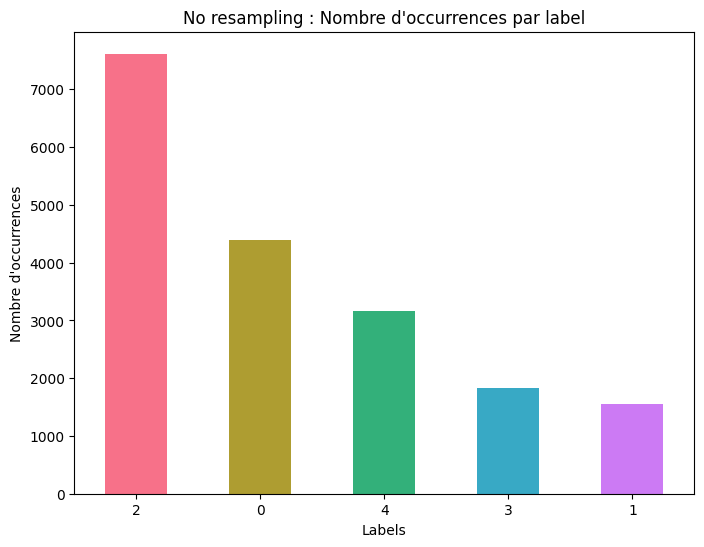

In [29]:
if resampling==True :
    # On compte les éléments de chaque classe
    count_class = y_train.value_counts().to_dict()
    print(count_class)
    print(classes_mapping)

    df_train = sampling_for_imbalanced_data(df_train, resampling_method, classes_mapping)

    if resampling_method=="ADASYN" :
        if follow_adasyn == 0 :
            df_train = sampling_for_imbalanced_data(df_train, "random_under_sampling", classes_mapping)
        elif follow_adasyn == 1 :
            df_train = sampling_for_imbalanced_data(df_train, "random_over_sampling", classes_mapping)

    plot_label_occurences(df_train, resampling_method)

else :
    plot_label_occurences(df_train, "No resampling")

## 7. Anomaly detection

By using the reconstruction error as anomaly score, we can try and spot anomalies in the classes and even bad channels. For a simple example, we will just use a threshold, if the anomaly score is higher, we will mark the epoch as an anomaly and delete it form the dataframe

In [30]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns


def anomaly_detection_with_AE(df, n_epochs=50, encoding_dimension=8, percentage_of_anomalies=1) :
    """Perform anomaly detection using an Autoencoder neural network on a DataFrame with time-series data
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing a 'data' column with time-series data and a 'label' column with class labels
    n_epochs : int, optional
        Number of training epochs for the Autoencoder (default is 50)
    encoding_dimension : int, optional
        Dimension of the latent representation in the Autoencoder (default is 8)
    percentage_of_anomalies : int, optional
        Percentage of anomalies in the data for setting the prediction loss threshold (default is 2)
    Returns
    -------
    pandas.DataFrame
        DataFrame with filtered data, excluding outliers identified by the Autoencoder
    """
    df_length = len(df['data'])
    # Check if some of the values from the dataframe are NaN (that would raise an error)*
    # If so, we delete them
    has_nan = df['data'].apply(lambda x: np.isnan(x).any() if isinstance(x, np.ndarray) else False)
    if has_nan.any():
        df = df.loc[~has_nan]
        print(f"Il y a des données manquantes, données supprimées : {df_length - len(df['data'])}")

    df = df.reset_index(drop=True)
        
    X = []
    for i in range(df_length) :
        X.append(df['data'][i].ravel())

    y = df['label']
    # Normalisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Créer le modèle de l'autoencodeur
    input_dim = X_scaled.shape[1]  # Dimension des données d'entrée
    encoding_dim = encoding_dimension  # Dimension de la représentation latente

    # Encodeur
    input_layer = keras.layers.Input(shape=(input_dim,))
    encoder = tf.keras.Sequential([
        keras.layers.Dense(encoding_dim*4, activation='relu', kernel_initializer='he_normal'),
        keras.layers.Dense(encoding_dim*2, activation='relu', kernel_initializer='he_normal'),
        keras.layers.Dense(encoding_dim, activation='relu', kernel_initializer='he_normal')])(input_layer)
    encoder_model = keras.models.Model(inputs=input_layer, outputs=encoder)

    # Décodeur
    decoder_input = keras.layers.Input(shape=(encoding_dim,))
    decoder = tf.keras.Sequential([
        keras.layers.Dense(encoding_dim*2, activation='relu', kernel_initializer='he_normal'),
        keras.layers.Dense(encoding_dim*4, activation='relu', kernel_initializer='he_normal'),
        keras.layers.Dense(input_dim, activation='sigmoid', kernel_initializer='he_normal')])(decoder_input)
    decoder_model = keras.models.Model(inputs=decoder_input, outputs=decoder)

    # Autoencodeur complet
    autoencoder_input = keras.layers.Input(shape=(input_dim,))
    encoded = encoder_model(autoencoder_input)
    decoded = decoder_model(encoded)
    autoencoder = keras.models.Model(inputs=autoencoder_input, outputs=decoded)

    # Compiler le modèle
    autoencoder.compile(optimizer="adam", loss="mean_squared_error")

    # Entraîner l'autoencodeur
    autoencoder.fit(X_scaled, X_scaled, epochs=n_epochs, batch_size=64, shuffle=True)

    prediction = autoencoder.predict(X_scaled)
    # Get the mean absolute error between actual and reconstruction/prediction
    prediction_loss = tf.keras.losses.mae(prediction, X_scaled)
    # Check the prediction loss threshold for 2% of outliers
    loss_threshold = np.percentile(prediction_loss, 100 - percentage_of_anomalies)
    print(f'The prediction loss threshold for {percentage_of_anomalies}% of outliers is {loss_threshold:.2f}')
    # Visualize the threshold
    sns.histplot(prediction_loss, bins=30, alpha=0.8)
    palette = sns.color_palette()
    # Tracer la ligne verticale avec la même couleur
    plt.axvline(x=loss_threshold, color=palette[0])

    outlier_indices = np.where(prediction_loss > loss_threshold)[0]
    # Now, the `outlier_indices` variable contains the indices of elements in X_scaled
    # that have prediction_loss above the loss_threshold.
    print("number of outliers :", len(outlier_indices))
    
    df_final = df.drop(outlier_indices)

    X_new = [X[i] for i in range(len(X)) if i not in outlier_indices]
    y = y[:-len(outlier_indices)]
    
    X_final = []
    for i in range(len(X_new)):
        X_final.append((np.array(X_new[i])).reshape((2, int(len(df['data'][0][0])))))
    
    df_final['data'] = X_final
    
    return df_final

To start with, we will delete 1% of the data from each class based on the threshold loss

You can modify this value as you wish when you call the function `anomaly_detection_with_AE`

In [31]:
if anomaly_detection==True :
    df_dict = DataFrame_to_Dictionnary(df_train, classes_mapping)

    df_new = []
    for i in range(len(df_dict)) :
        df = df_dict["Condition_{}".format(classes_mapping[i])]
        df_final = anomaly_detection_with_AE(df, n_epochs=50, encoding_dimension=16, percentage_of_anomalies=percentage_of_anomalies)
        df_new.append(df_final)
    df_train = pd.concat(df_new, ignore_index=True)
    df_train = df_train.reset_index(drop=True)
    del df_new

## 7. Visualizing the Data

This section uses PCA decomposition to plot the multidimensionnal data on the 2D space in order to better understand why the model has such a hard time differencitating between certain classes

In [32]:
from sklearn.decomposition import PCA

def pca_conversion(df, n_components=2) :
    """Perform PCA (Principal Component Analysis) on a DataFrame's 'data' column and return a new DataFrame
    
    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing a 'data' column with multidimensional arrays or numerical values
        and a 'label' column containing integers
    n_components : int, optional
        Number of principal components to retain (default is 2)
    Returns
    -------
    pandas.DataFrame
        DataFrame with transformed 'data' column using PCA and an additional 'label' column
    """
    # On crée une instance PCA avec deux composantes principales
    pca = PCA(n_components)
    # On reset les index de la dataframe pour éviter les erreurs d'indexation
    df = df.reset_index(drop=True)
    # Cette partie du code sert à tranformer chaque élément de la colonne 'data'
    # qui peuvent être des arrays multidimensionnels ou des floats ou int en une liste 
    # cette liste est alors rangée dans X à la place équivalente à la ligne de la dataframe
    # Cette étape doit bien sur être adaptée en fonction de la nature des données à convertir
    # Dans cet exemple, les données de data étaient des array de taille (2,3000)
    # On en a donc fait une liste qui est donc de taille (1,6000), exploitable par la méthode pca
    y = df['label']
    X = []
    for i in range(len(df['data'])) :
        X.append(df['data'][i].ravel())

    X_pca = pca.fit_transform(X)
    df_pca = pd.DataFrame({'data': X_pca.tolist(), 'label': y})

    return df_pca


def plot_2d_space(X, y, classes_mapping=None, n_samples=500, title='Classes', color_map='coolwarm'):
    """Plot a 2D representation of data points with distinct colors and markers for each class
    
    Parameters
    ----------
    X : array-like
        2D array or list containing the data points to be plotted
    y : array-like
        1D array or list containing class labels corresponding to each data point in X
    classes_mapping : dict, optional
        Dictionary mapping class labels to human-readable class names (default is None)
    n_samples : int, optional
        Maximum number of samples to be plotted for each class (default is 500)
    title : str, optional
        Title of the plot (default is 'Classes')
    color_map : str, optional
        Colormap name for generating distinct colors for each class (default is 'coolwarm')
    Returns
    -------
    None
        Displays a 2D scatter plot of the data points with distinct colors and markers for each class
    """
    nouvelle_largeur = 800
    nouvelle_hauteur = 600
    dpi = 80
    plt.figure(figsize=(nouvelle_largeur / dpi, nouvelle_hauteur / dpi))

    # Obtenir la liste des étiquettes uniques
    unique_labels = np.unique(y)
    
    # Utiliser une palette de couleurs pour générer des couleurs distinctes
    colors = plt.get_cmap(color_map)(np.linspace(0, 1, len(unique_labels)))

    # Utiliser une liste de marqueurs distincts
    markers = ['o', 's', 'v', 'D', 'p', '*', 'H', 'X', '8', '>', '<', '^', 'd', '|', '_']

    for i, label in enumerate(unique_labels):
        class_indices = (y == label)             
        class_X = [X[j] for j in range(len(X)) if class_indices[j]]
        class_X = np.array(class_X)  # Convert the list to a NumPy array
        if len(class_X) > n_samples:
            class_X = class_X[:n_samples]
        plt.scatter(class_X[:, 0], class_X[:, 1], c=[colors[i]], marker=markers[i], label=classes_mapping[label])

    plt.legend(loc='upper right')
    plt.title(title)
    plt.show()

We first plot all the classes combined on the same graph

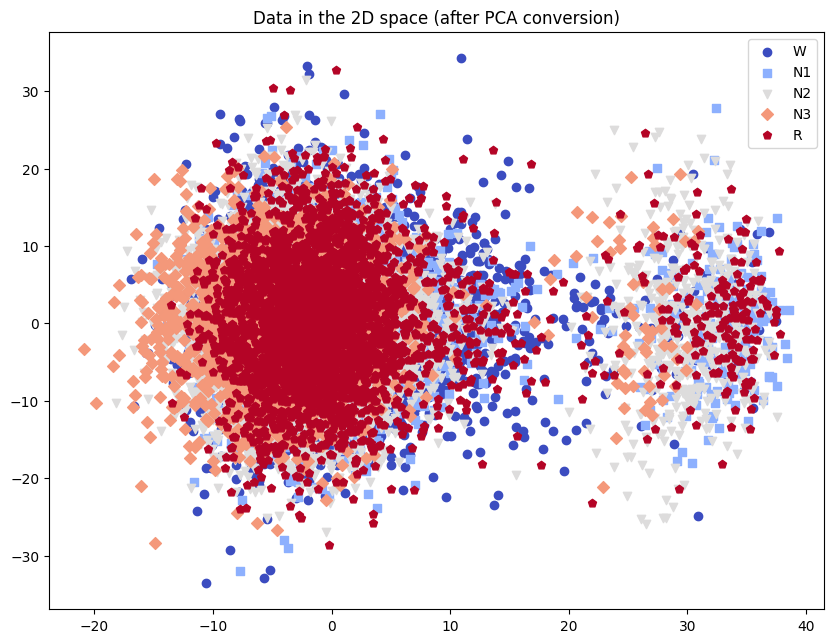

In [33]:
# Getting the most represented class label
max_value_key = max(count_occurences(df_train, 'label'), key=count_occurences(df_train, 'label').get) 
# getting the nulber of instances in the class to use it as max nb of samples plotted for each class (this will plot each sample from each class)
max_value = count_occurences(df_train, 'label')[max_value_key]

df_pca = pca_conversion(df_train)

plot_2d_space(df_pca['data'], df_pca['label'], classes_mapping, n_samples=max_value, title='Data in the 2D space (after PCA conversion)')

Then we plot them separately

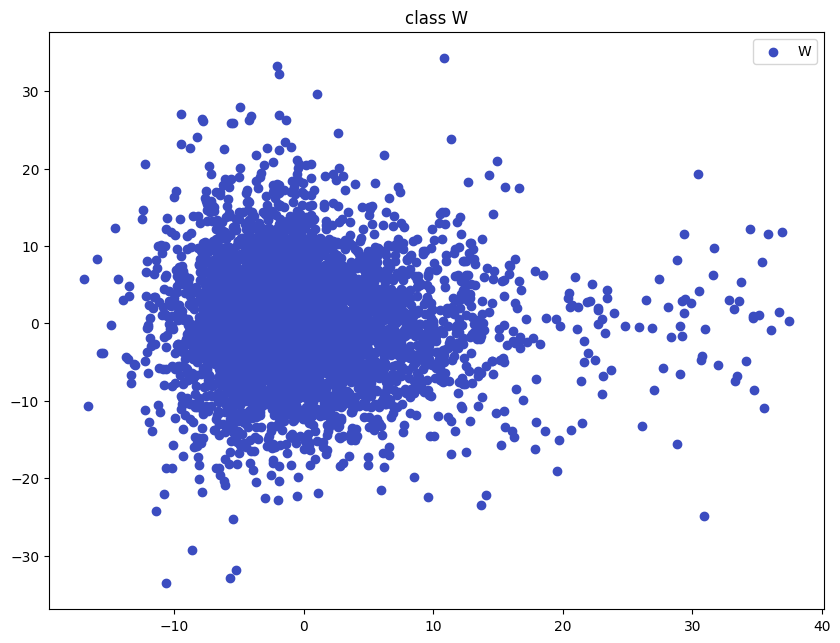

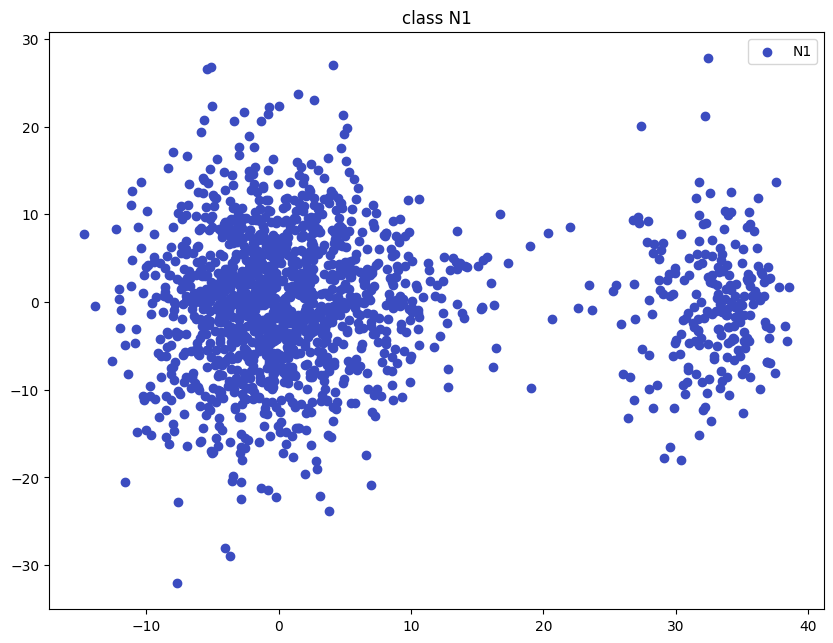

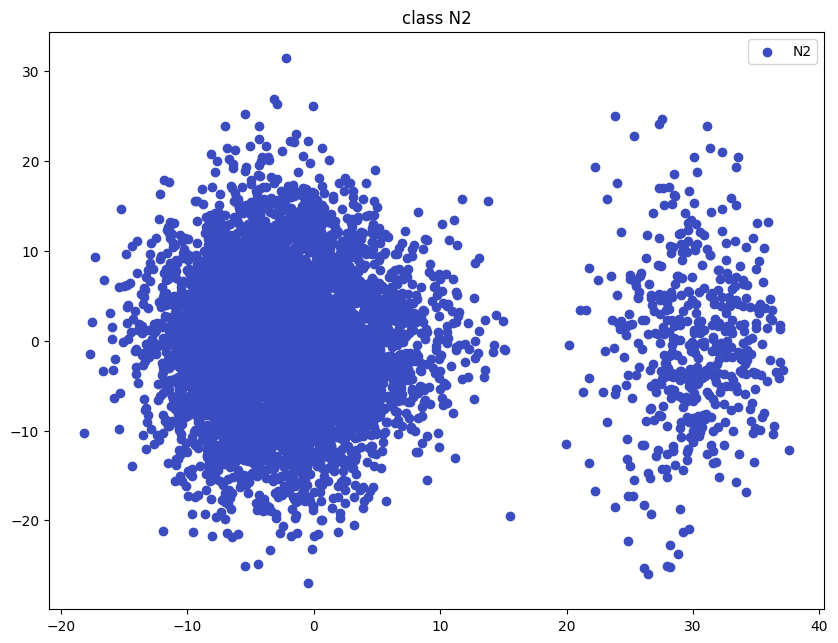

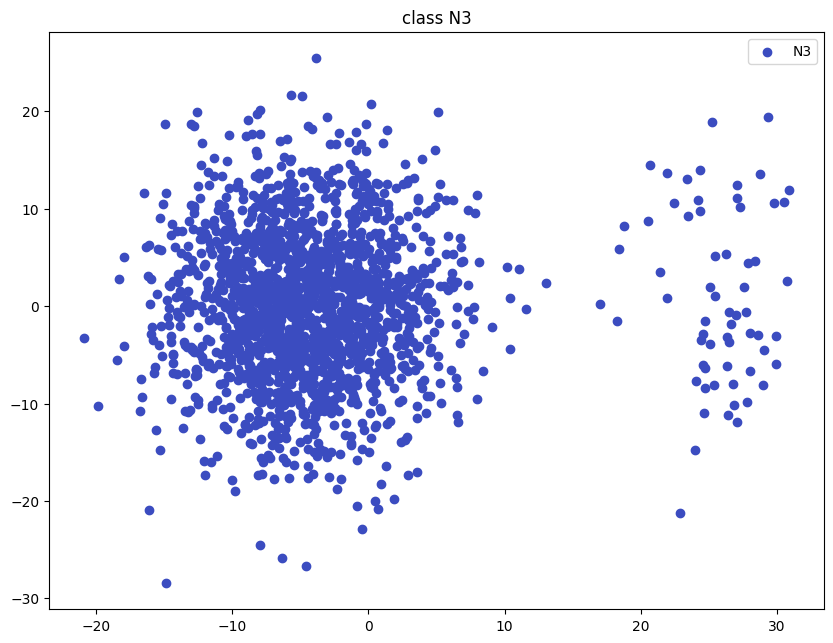

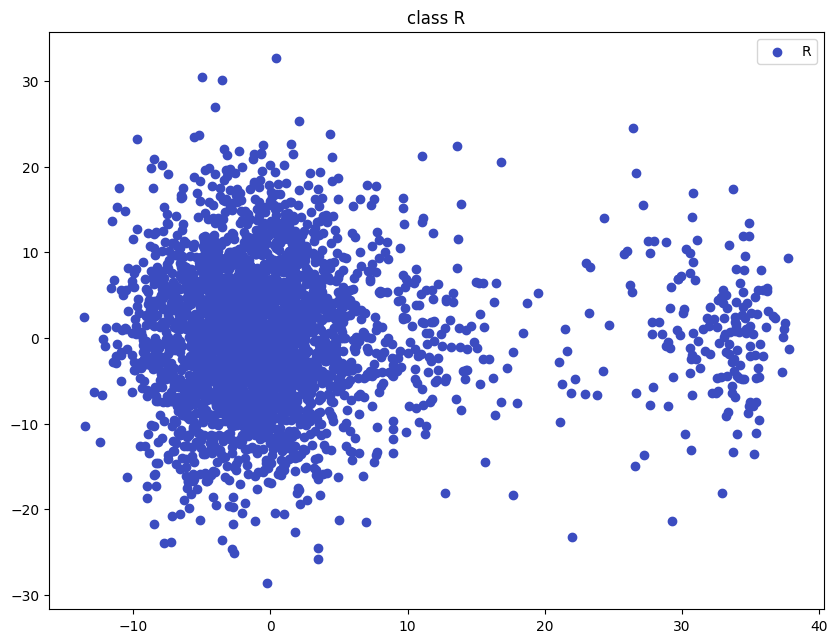

In [34]:
df_dict = DataFrame_to_Dictionnary(df_pca, classes_mapping)

for i in range(len(df_dict)) :
    plot_2d_space(df_dict["Condition_{}".format(classes_mapping[i])]['data'], df_dict["Condition_{}".format(classes_mapping[i])]['label'], classes_mapping, n_samples=max_value, title='class {}'.format(classes_mapping[i]))

## 8. Data Augmentation

### 8.1. **Brain Waves**

There are several types of brain waves, classified based on their frequency and amplitude. The primary categories of brain waves are:

1. Delta Waves (0.5-4 Hz): Delta waves are the slowest brain waves and are associated with deep sleep. They have the highest amplitude and are often seen in infants and during stages of deep sleep in adults.

2. Theta Waves (4-8 Hz): Theta waves are present during light sleep, deep relaxation, and the early stages of meditation. They are also associated with daydreaming and creative thinking.

3. Alpha Waves (8-13 Hz): Alpha waves are dominant during relaxed wakefulness and are often seen when the eyes are closed but the individual is awake and not actively processing information. They are associated with a state of calm and are sometimes referred to as "idle" brain waves.

4. Beta Waves (13-30 Hz): Beta waves are associated with active, alert, and focused mental activity. They are prominent during wakefulness and cognitive tasks, such as problem-solving and decision-making.

5. Gamma Waves (30-100 Hz): Gamma waves are the fastest brain waves and are associated with higher cognitive functions, such as perception, problem-solving, and consciousness. They are also involved in the binding of different sensory inputs into a unified perception.

These brain waves are not strictly limited to specific states of consciousness, and their presence can overlap. For example, during certain activities, you may observe a mix of alpha, beta, and theta waves.

In [35]:
from scipy.fft import fft

def calculate_psd(epoch, sampling_frequency=100):
    """Calculate the Power Spectral Density (PSD) of a given epoch using Fast Fourier Transform (FFT)

    Parameters
    ----------
    epoch : array-like
        One-dimensional array or list containing the epoch data
    sampling_frequency : int, optional
        Sampling frequency of the data (default is 100)
    Returns
    -------
    np.ndarray
        One-dimensional NumPy array representing the power spectral density of the epoch
    """
    # Apply Fast Fourier Transform
    fft_result = fft(epoch)
    
    # Calculate power spectral density
    psd = np.abs(fft_result) ** 2
    
    # Normalize PSD by the number of data points and sampling frequency
    psd = psd / (len(epoch) * sampling_frequency)
    
    # Return the PSD
    return psd


def calculate_band_power(epoch, sampling_frequency, freq_range):
    """Calculate the spectral power in a given frequency band for a given epoch

    Parameters
    ----------
    epoch : array-like
        One-dimensional array or list containing the epoch data
    sampling_frequency : int
        Sampling frequency of the data
    freq_range : tuple
        Frequency range for which the power should be calculated (e.g., (low_freq, high_freq))
    Returns
    -------
    float
        Value representing the spectral power in the specified frequency band for the given epoch
    """
    psd = calculate_psd(epoch, sampling_frequency)

    freq = np.fft.fftfreq(len(epoch), d=1/sampling_frequency)

    # Find indices corresponding to the frequency range
    indices = np.where((freq >= freq_range[0]) & (freq <= freq_range[1]))[0]
    
    # Sum the power within the specified frequency range
    band_power = np.sum(psd[indices])
    
    return band_power


def brainwaves_df(df, sampling_frequency=100) : 
    """Calculate and append brainwave power features to a DataFrame containing EEG data

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing a 'data' column with EEG data
    sampling_frequency : int, optional
        Sampling frequency of the EEG data (default is 100)
    Returns
    -------
    pandas.DataFrame
        DataFrame with appended columns for delta, theta, alpha, beta, and gamma brainwave power
    """ 
    # Define brainwave frequency ranges
    delta_range = (0.5, 4)
    theta_range = (4, 8)
    alpha_range = (8, 13)
    beta_range = (13, 30)
    gamma_range = (30, 100)

    data = []

    for i in range (len(df['data'])) :
        delta_power = np.zeros((len(df['data'][0]), 1))
        theta_power = np.zeros((len(df['data'][0]), 1))
        alpha_power = np.zeros((len(df['data'][0]), 1))
        beta_power = np.zeros((len(df['data'][0]), 1))
        gamma_power = np.zeros((len(df['data'][0]), 1))

        for j in range (len(df['data'][0])) :

            epoch = df['data'][i][j]

            # Calculate band powers for each brainwave frequency range
            delta_power[j] = calculate_band_power(epoch, sampling_frequency, delta_range)
            theta_power[j] = calculate_band_power(epoch, sampling_frequency, theta_range)
            alpha_power[j] = calculate_band_power(epoch, sampling_frequency, alpha_range)
            beta_power[j] = calculate_band_power(epoch, sampling_frequency, beta_range)
            gamma_power[j] = calculate_band_power(epoch, sampling_frequency, gamma_range)
    
        # Append the results to the data list
        data.append([delta_power, theta_power, alpha_power, beta_power, gamma_power])

    # Create a DataFrame
    column_names = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    df_waves = pd.DataFrame(data, columns=column_names)

    df = df.join(df_waves)
    return df

In [36]:
if additional_features == True :
    df_train = brainwaves_df(df_train, sampling_frequency=100)
    df_train.head()

### 8.2. **Pearson Cross-Correlation Coefficient**

The Pearson cross-correlation coefficient, often simply referred to as "cross-correlation" or "correlation," measures the linear similarity between two signals (or time series). It is a statistical measure indicating the extent to which variations in two signals are linearly synchronized. It can be beneficial in our case because we only have two EEG channels per recording.

In [37]:
def cor_coef(df) :
    """Calculate the Pearson Cross-Correlation Coefficient for pairs of time-series data in a DataFrame

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing a 'data' column with pairs of time-series data
    Returns
    -------
    pandas.DataFrame
        DataFrame with an added column for the Pearson Cross-Correlation Coefficient
    """
    data = []

    for i in range (len(df['data'])) :  
        
        correlation = np.corrcoef(df['data'][i][0], df['data'][i][1])[0, 1]
        data.append(correlation)

    df_cor_coef = pd.DataFrame(data, columns=['Pearson Cross-Correlation Coefficient'])
    df = df.join(df_cor_coef)
    return df

In [38]:
if additional_features == True :
    df_train = cor_coef(df_train)
    df.head()

We also need to add additional features to the valid and test dataset if we chose `additional_features=True`. To do this we convert them into dataframes, add the features, and then wrap them into datasets using the DataFrame_to_ConcatDataset method.

In [39]:
if additional_features == True :
    valid_df = ConcatDataset_to_Dataframe(valid_ds)
    test_df = ConcatDataset_to_Dataframe(test_ds)
    valid_df = brainwaves_df(valid_df, sampling_frequency=100)
    test_df = brainwaves_df(test_df, sampling_frequency=100)
    valid_df = cor_coef(valid_df)
    test_df = cor_coef(test_df)

## 9. Dataframe to Dataset
After working with the data in the form of a Dataframe, we need to convert it back to a Dataset in order to use it as an input for our neural network

In [40]:
if additional_features == False :
    def DataFrame_to_ConcatDataset(df):
        """Converts a pandas.DataFrame into a torch.utils.data.dataset.ConcatDataset
        
        Parameters
        ----------
        df : pandas.DataFrame
            DataFrame with columns ['data'], ['label'], ['dataset_idx']
            
        Returns
        -------
        concatdataset : torch.utils.data.dataset.ConcatDataset
            ConcatDataset with datasets containing data and labels from the DataFrame
        """    
        unique_dataset_indices = df['dataset_idx'].unique()
        datasets = []

        for dataset_idx in unique_dataset_indices:
            subset_df = df[df['dataset_idx'] == dataset_idx]

            data = [torch.from_numpy(np.array(d)) for d in subset_df['data']]
            label = subset_df['label'].values

            dataset = EpochsDataset(data, label)
            datasets.append(dataset)

        concatdataset = ConcatDataset(datasets)
        
        return concatdataset
    
else :
    class EpochsDatasetv2(Dataset):
        """Class to expose an MNE Epochs object with additional features as a PyTorch dataset.

        Parameters
        ----------
        epochs_data : np.ndarray
            The epochs data, shape (n_epochs, n_channels, n_times).
        additional_features: Dict[str, List[torch.Tensor]]
            A dictionary containing the additional features for each channel.
            The keys are the feature names, and the values are lists of torch tensors.
        epochs_labels : np.ndarray
            The epochs labels, shape (n_epochs,)
        subj_nb: None | int
            Subject number.
        rec_nb: None | int
            Recording number.
        transform : callable | None
            The function to eventually apply to each epoch for preprocessing (e.g. scaling). Defaults to None.
        """
        def __init__(self, epochs_data, additional_features, epochs_labels, subj_nb=None,
                    rec_nb=None, transform=None):
            assert len(epochs_data) == len(epochs_labels)
            self.epochs_data = epochs_data
            self.additional_features = additional_features
            self.epochs_labels = epochs_labels
            self.subj_nb = subj_nb
            self.rec_nb = rec_nb
            self.transform = transform

        def __len__(self):
            return len(self.epochs_labels)

        def __getitem__(self, idx):
            X, y = self.epochs_data[idx], self.epochs_labels[idx]
            additional_X = {feature_name: feature_values[idx] for feature_name, feature_values in self.additional_features.items()}

            if self.transform is not None:
                X = self.transform(X)

            # Convert to torch tensors
            X = torch.as_tensor(X[None, ...])
            additional_X = {feature_name: torch.as_tensor(values) for feature_name, values in additional_X.items()}

            return {'eeg_data': X, 'additional_features': additional_X, 'label': y}
        

    def DataFrame_to_ConcatDataset(df) :
        """Convert a DataFrame with features and labels into a PyTorch ConcatDataset
    
        Parameters
        ----------
        df : pandas.DataFrame
            DataFrame containing columns 'data', 'Alpha', 'Beta', 'Gamma', 'Delta', 'Theta',
            'Pearson Cross-Correlation Coefficient', and 'label'
        Returns
        -------
        torch.utils.data.ConcatDataset
            Concatenated PyTorch dataset containing data, additional features, and labels
        """
        unique_dataset_indices = df['dataset_idx'].unique()
        datasets = []

        for dataset_idx in unique_dataset_indices:
            subset_df = df[df['dataset_idx'] == dataset_idx]

            data = [torch.from_numpy(np.array(d)) for d in subset_df['data']]
            label = subset_df['label'].values
            # Création d'un dictionnaire pour les fonctionnalités supplémentaires
            additional_features = {
            'alpha': [torch.from_numpy(np.array(a)) for a in df['Alpha']],
            'beta': [torch.from_numpy(np.array(b)) for b in df['Beta']],
            'gamma': [torch.from_numpy(np.array(g)) for g in df['Gamma']],
            'delta': [torch.from_numpy(np.array(d)) for d in df['Delta']],
            'theta': [torch.from_numpy(np.array(t)) for t in df['Theta']],
            'pearson': [torch.tensor(c) for c in df['Pearson Cross-Correlation Coefficient']]
            }

            dataset = EpochsDatasetv2(data, additional_features, label)
            datasets.append(dataset)

        concatdataset = ConcatDataset(datasets)
        
        return concatdataset

In [41]:
train_ds = DataFrame_to_ConcatDataset(df_train)
del(df_train) # we don't need it anymore --> delete to save some memory

If `additional_features=True` was chosen, we need to wrap the valid and test dataframes with additional features into Datasets

In [42]:
if additional_features == True :
    valid_ds = DataFrame_to_ConcatDataset(valid_df)
    test_ds = DataFrame_to_ConcatDataset(test_df)

### Sanity check :

If a resampling was performed, all the classes should be attributed a weight of 1. We compute the weights with the following :

In [43]:
# Computing class weight
from sklearn.utils.class_weight import compute_class_weight

train_y = np.concatenate([ds.epochs_labels for ds in train_ds.datasets])
class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
print(class_weights)

[0.84583808 2.37908916 0.48700105 2.03567508 1.17262093]


## 10. Creating the neural network

In this section, we will define our ConvNet architecture. 

By default, we use the sleep staging architecture of Chambon et al. (2018), which looks something like this (adapted from Banville et al. 2020):

![convnet](figures/convnet.png "SleepStagerChambon2018")

The **input**, on the left, is a 30-s window of `C` channels. By default we have set `C` to 2 by selecting the 2 available EEG channels in Sleep Physionet above.

The **output**, on the right, is a 5-dimensional vector where each dimension is matched to one of our 5 classes (W, N1, N2, N3 and R sleep stages).

In between, we have a succession of convolutional layers, max pooling, and nonlinearities. The feature maps are finally flattened and passed through a fully-connected layer.

We define the neural network in the following `torch.nn.Module` class:

In [44]:
from torch import nn


class SleepStagerChambon2018(nn.Module):
    """Sleep staging architecture from [1]_.
    
    Convolutional neural network for sleep staging described in [1]_.
    
    Parameters
    ----------
    n_channels : int
        Number of EEG channels.
    sfreq : float
        EEG sampling frequency.
    n_conv_chs : int
        Number of convolutional channels. Set to 8 in [1]_.
    time_conv_size_s : float
        Size of filters in temporal convolution layers, in seconds. Set to 0.5
        in [1]_ (64 samples at sfreq=128).
    max_pool_size_s : float
        Max pooling size, in seconds. Set to 0.125 in [1]_ (16 samples at
        sfreq=128).
    n_classes : int
        Number of classes.
    input_size_s : float
        Size of the input, in seconds.
    dropout : float
        Dropout rate before the output dense layer.
        
    References
    ----------
    .. [1] Chambon, S., Galtier, M. N., Arnal, P. J., Wainrib, G., &
           Gramfort, A. (2018). A deep learning architecture for temporal sleep
           stage classification using multivariate and multimodal time series.
           IEEE Transactions on Neural Systems and Rehabilitation Engineering,
           26(4), 758-769.
    """
    def __init__(self, n_channels, sfreq, n_conv_chs=8, time_conv_size_s=0.5,
                 max_pool_size_s=0.125, n_classes=5, input_size_s=30,
                 dropout=0.25, len_additional_features=11):
        super().__init__()

        time_conv_size = int(time_conv_size_s * sfreq)
        max_pool_size = int(max_pool_size_s * sfreq)
        input_size = int(input_size_s * sfreq)
        pad_size = time_conv_size // 2
        self.n_channels = n_channels
        if additional_features == False :
            len_last_layer = self._len_last_layer(
                n_channels, input_size, max_pool_size, n_conv_chs)
        else :
            len_last_layer = self._len_last_layer(
                n_channels, input_size, max_pool_size, n_conv_chs, len_additional_features)
            
        if n_channels > 1:
            self.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                1, n_conv_chs, (1, time_conv_size), padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(
                n_conv_chs, n_conv_chs, (1, time_conv_size),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(len_last_layer, n_classes)
        )

    if additional_features == False :
        @staticmethod
        def _len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs):
            return n_channels * (input_size // (max_pool_size ** 2)) * n_conv_chs
        

        def forward(self, x):
            """Forward pass.
            
            Parameters
            ---------
            x: torch.Tensor
                Batch of EEG windows of shape (batch_size, n_channels, n_times).
            """
            if self.n_channels > 1:
                x = self.spatial_conv(x)
                x = x.transpose(1, 2)

            x = self.feature_extractor(x)
            return self.fc(x.flatten(start_dim=1))
    
    else :
        @staticmethod
        def _len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs, len_additional_features):
            return (n_channels * (input_size // (max_pool_size ** 2)) * n_conv_chs) + len_additional_features
        

        def forward(self, eeg_data, additional_features):
            """Forward pass."""
            if self.n_channels > 1:
                eeg_data = self.spatial_conv(eeg_data)
                eeg_data = eeg_data.transpose(1, 2)
                
            eeg_data = self.feature_extractor(eeg_data)
            eeg_data = eeg_data.flatten(start_dim=1)
            # for the tensor size to go from ([128,11,1]) to ([128,11])
            additional_features = additional_features.view(-1, 11)

            # Concatenate EEG and additional features
            x = torch.cat([eeg_data, additional_features], dim=1)
            
            return self.fc(x)    

We instantiate our ConvNet with the following:

In [45]:
sfreq = raws[0].info['sfreq']  # Sampling frequency
n_channels = raws[0].info['nchan']  # Number of channels

model = SleepStagerChambon2018(n_channels, sfreq, n_classes=5)

Depending on whether a CUDA-enabled GPU is available, we can move the model to the GPU and perform the training there. This can enable significant speed-ups, but is not strictly required for this tutorial.

In [46]:
print(f'Using device \'{device}\'.')
model = model.to(device)

Using device 'cpu'.


## 11. Train and monitor network

We are almost ready to finally train our ConvNet!

We first need to define `DataLoader`s. `DataLoader` is a pytorch object that wraps a dataset and makes it easy to obtain batches of examples to feed to our neural network.

In [47]:
from torch.utils.data import DataLoader

# Create dataloaders
train_batch_size = 128  # Important hyperparameter
valid_batch_size = 256  # Can be made as large as what fits in memory; won't impact performance
num_workers = 0  # Number of processes to use for the data loading process; 0 is the main Python process

loader_train = DataLoader(
    train_ds, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
loader_valid = DataLoader(
    valid_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
loader_test = DataLoader(
    test_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)

Next, we define a few functions to carry out our training and validation loops:

In [48]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

def _do_train(model, loader, optimizer, criterion, device, scheduler, metric, additional_features=additional_features):
    # training loop
    model.train()
    
    train_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
     
    if additional_features == True :
        for idx_batch, data in enumerate(loader):
            optimizer.zero_grad()
            batch_x = data['eeg_data'].to(device=device, dtype=torch.float32)
            batch_y = data['label'].to(device=device, dtype=torch.int64)
            batch_alpha = data['additional_features']['alpha'].to(device=device, dtype=torch.float32)
            batch_beta = data['additional_features']['beta'].to(device=device, dtype=torch.float32)
            batch_gamma = data['additional_features']['gamma'].to(device=device, dtype=torch.float32)
            batch_delta = data['additional_features']['delta'].to(device=device, dtype=torch.float32)
            batch_theta = data['additional_features']['theta'].to(device=device, dtype=torch.float32)
            batch_pearson = data['additional_features']['pearson'].to(device=device, dtype=torch.float32)
            batch_pearson = batch_pearson.unsqueeze(1).unsqueeze(2)

            additional_features = torch.cat([batch_alpha, batch_beta, batch_gamma, batch_delta, batch_theta, batch_pearson], dim=1)
            output = model.forward(batch_x, additional_features)

            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            
            y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
            y_true_all.append(batch_y.cpu().numpy())

            train_loss[idx_batch] = loss.item()

    else :
        for idx_batch, (batch_x, batch_y) in enumerate(loader):
            optimizer.zero_grad()
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_y = batch_y.to(device=device, dtype=torch.int64)

            output = model(batch_x)
            loss = criterion(output, batch_y)

            loss.backward()
            optimizer.step()
            
            y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
            y_true_all.append(batch_y.cpu().numpy())

            train_loss[idx_batch] = loss.item()
            
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)
    scheduler.step(np.mean(train_loss))
    
    return np.mean(train_loss), perf, balanced_accuracy_score(y_true, y_pred)
        

def _validate(model, loader, criterion, device, metric, additional_features=additional_features):
    # validation loop
    model.eval()
    
    val_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = list(), list()
    with torch.no_grad():
        if additional_features == True :
            for idx_batch, data in enumerate(loader):
                batch_x = data['eeg_data'].to(device=device, dtype=torch.float32)
                batch_y = data['label'].to(device=device, dtype=torch.int64)
                batch_alpha = data['additional_features']['alpha'].to(device=device, dtype=torch.float32)
                batch_beta = data['additional_features']['beta'].to(device=device, dtype=torch.float32)
                batch_gamma = data['additional_features']['gamma'].to(device=device, dtype=torch.float32)
                batch_delta = data['additional_features']['delta'].to(device=device, dtype=torch.float32)
                batch_theta = data['additional_features']['theta'].to(device=device, dtype=torch.float32)
                batch_pearson = data['additional_features']['pearson'].to(device=device, dtype=torch.float32)
                batch_pearson = batch_pearson.unsqueeze(1).unsqueeze(2)
                additional_features = torch.cat([batch_alpha, batch_beta, batch_gamma, batch_delta, batch_theta, batch_pearson], dim=1)

                output = model.forward(batch_x, additional_features)
                loss = criterion(output, batch_y)
                val_loss[idx_batch] = loss.item()
                
                y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
                y_true_all.append(batch_y.cpu().numpy())

        else :
            for idx_batch, (batch_x, batch_y) in enumerate(loader):
                batch_x = batch_x.to(device=device, dtype=torch.float32)
                batch_y = batch_y.to(device=device, dtype=torch.int64)
                output = model.forward(batch_x)

                loss = criterion(output, batch_y)
                val_loss[idx_batch] = loss.item()
                
                y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
                y_true_all.append(batch_y.cpu().numpy())
            
    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)

    return np.mean(val_loss), perf, balanced_accuracy_score(y_true, y_pred)
    

def train(model, loader_train, loader_valid, optimizer, scheduler, criterion, n_epochs, 
          patience, device, metric=None):
    """Training function.
    
    Parameters
    ----------
    model : instance of nn.Module
        The model.
    loader_train : instance of Sampler
        The generator of EEG samples the model has to train on.
        It contains n_train samples
    loader_valid : instance of Sampler
        The generator of EEG samples the model has to validate on.
        It contains n_val samples. The validation samples are used to
        monitor the training process and to perform early stopping
    optimizer : instance of optimizer
        The optimizer to use for training.
    n_epochs : int
        The maximum of epochs to run.
    patience : int
        The patience parameter, i.e. how long to wait for the
        validation error to go down.
    metric : None | callable
        Metric to use to evaluate performance on the training and
        validation sets. Defaults to balanced accuracy.
        
    Returns
    -------
    best_model : instance of nn.Module
        The model that led to the best prediction on the validation
        dataset.
    history : list of dicts
        Training history (loss, accuracy, etc.)
    """
    best_valid_loss = np.inf
    best_model = copy.deepcopy(model)
    waiting = 0
    history = list()
    
    if metric is None:
        metric = balanced_accuracy_score
        
    print('epoch \t train_loss \t valid_loss \t train_perf \t valid_perf \t train_accuracy \t valid_accuracy')
    print('--------------------------------------------------------------------------------------------------------------------------------')

    for epoch in range(1, n_epochs + 1):
        train_loss, train_perf, train_balanced_accuracy = _do_train(
            model, loader_train, optimizer, criterion, device, scheduler, metric=metric)
        valid_loss, valid_perf, valid_balanced_accuracy = _validate(
            model, loader_valid, criterion, device, metric=metric)
        history.append(
            {'epoch': epoch, 
             'train_loss': train_loss, 'valid_loss': valid_loss,
             'train_perf': train_perf, 'valid_perf': valid_perf})
        
        print(f'{epoch} \t {train_loss:0.4f} \t {valid_loss:0.4f} '
              f'\t {train_perf:0.4f} \t {valid_perf:0.4f} \t {train_balanced_accuracy:0.4f} \t\t {valid_balanced_accuracy:0.4f}')

        # model saving
        if valid_loss < best_valid_loss:
            print(f'best val loss {best_valid_loss:.4f} -> {valid_loss:.4f}')
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            waiting = 0
        else:
            waiting += 1

        # model early stopping
        if waiting >= patience:
            print(f'Stop training at epoch {epoch}')
            print(f'Best val loss : {best_valid_loss:.4f}')
            break

    return best_model, history

Two critical pieces of the training process are the **optimizer** and the **criterion**.

* The **optimizer** implements the parameter update procedure. Here, we use `Adam`, a popular adaptive gradient descent optimizer for deep neural networks.
* The **criterion**, or loss function, is used to measure how well the neural network performs on an example. Here, we use the standard multiclass cross-entropy loss.

In [49]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=0)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.15, patience=3, verbose=True)
criterion = CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device))

We can now launch our training loop. The maxmium number of training epochs (or "passes" through the training set) is set with `n_epochs`. The `patience` hyperparameter controls how many epochs we will wait for before stopping the training process if there is no improvement on the validation set.

In [50]:
n_epochs = 15
patience = 5

best_model, history = train(
    model, loader_train, loader_valid, optimizer, scheduler, criterion, n_epochs, patience, 
    device, metric=cohen_kappa_score)

epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf 	 train_accuracy 	 valid_accuracy
--------------------------------------------------------------------------------------------------------------------------------
1 	 1.1417 	 0.9566 	 0.3330 	 0.4332 	 0.4938 		 0.6108
best val loss inf -> 0.9566
2 	 0.8380 	 0.8370 	 0.5333 	 0.5247 	 0.6359 		 0.6738
best val loss 0.9566 -> 0.8370
3 	 0.7520 	 0.8765 	 0.6003 	 0.4966 	 0.6828 		 0.6673
4 	 0.7085 	 0.7552 	 0.6275 	 0.5904 	 0.7077 		 0.7010
best val loss 0.8370 -> 0.7552
5 	 0.6848 	 0.7514 	 0.6421 	 0.5992 	 0.7185 		 0.7062
best val loss 0.7552 -> 0.7514
6 	 0.6740 	 0.7621 	 0.6503 	 0.5920 	 0.7268 		 0.7034
7 	 0.6640 	 0.8227 	 0.6532 	 0.5660 	 0.7284 		 0.6728
8 	 0.6605 	 0.7669 	 0.6588 	 0.5840 	 0.7291 		 0.6961
9 	 0.6414 	 0.7362 	 0.6678 	 0.6182 	 0.7402 		 0.7006
best val loss 0.7514 -> 0.7362
10 	 0.6467 	 0.8136 	 0.6672 	 0.5635 	 0.7416 		 0.6869
11 	 0.6372 	 0.7270 	 0.6698 	 0.6162 	 0.7405 		 0.710

Next, we visualize the results of our training.

First, the training curves show how the loss and accuracy improved across training epochs. We use [Cohen's kappa](https://scikit-learn.org/stable/modules/model_evaluation.html#cohen-kappa) (instead of the standard accuracy) to better reflect performance under class imbalance and allow comparison with results from the literature.

Text(0, 0.5, "Cohen's kappa")

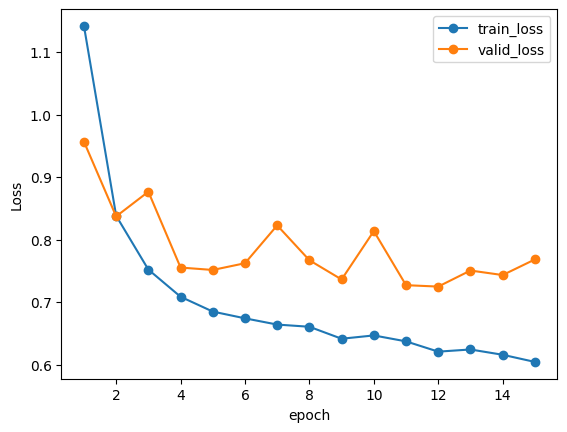

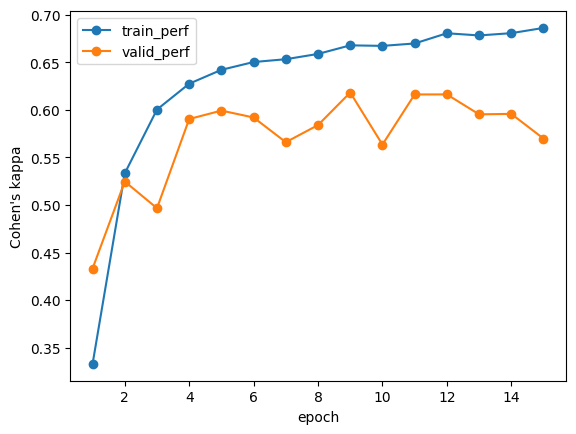

In [51]:
# Visualizing the learning curves

history_df = pd.DataFrame(history)
ax1 = history_df.plot(x='epoch', y=['train_loss', 'valid_loss'], marker='o')
ax1.set_ylabel('Loss')
ax2 = history_df.plot(x='epoch', y=['train_perf', 'valid_perf'], marker='o')
ax2.set_ylabel('Cohen\'s kappa')

We expect the loss to decrease and the Cohen's kappa to increase as more and more training epochs are performed.

We also measure the performance on the test set, which was not seen during training. This gives us a better estimate of the generalization performance of our ConvNet.

In [52]:
# Compute test performance
best_model.eval()

y_pred_all, y_true_all = list(), list()
if additional_features == True :
    for batch in loader_test:
        batch_x, batch_y  = batch['eeg_data'], batch['label']
        batch_alpha = batch['additional_features']['alpha'].to(device=device, dtype=torch.float32)
        batch_beta = batch['additional_features']['beta'].to(device=device, dtype=torch.float32)
        batch_gamma = batch['additional_features']['gamma'].to(device=device, dtype=torch.float32)
        batch_delta = batch['additional_features']['delta'].to(device=device, dtype=torch.float32)
        batch_theta = batch['additional_features']['theta'].to(device=device, dtype=torch.float32)
        batch_pearson = batch['additional_features']['pearson'].to(device=device, dtype=torch.float32)
        batch_pearson = batch_pearson.unsqueeze(1).unsqueeze(2)
        additional_features = torch.cat([batch_alpha, batch_beta, batch_gamma, batch_delta, batch_theta, batch_pearson], dim=1)
        batch_x = batch_x.to(device=device, dtype=torch.float32)
        batch_y = batch_y.to(device=device, dtype=torch.int64)
        output = model.forward(batch_x, additional_features)
        y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
        y_true_all.append(batch_y.cpu().numpy())
else :        
    for batch_x, batch_y in loader_test:
        batch_x = batch_x.to(device=device, dtype=torch.float32)
        batch_y = batch_y.to(device=device, dtype=torch.int64)
        output = model.forward(batch_x)
        y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
        y_true_all.append(batch_y.cpu().numpy())
    
y_pred = np.concatenate(y_pred_all)
y_true = np.concatenate(y_true_all)
rec_ids = np.concatenate(  # indicates which recording each example comes from
    [[i] * len(ds) for i, ds in enumerate(test_ds.datasets)])

test_bal_acc = balanced_accuracy_score(y_true, y_pred)
test_kappa = cohen_kappa_score(y_true, y_pred)

print(f'Test balanced accuracy: {test_bal_acc:0.3f}')
print(f'Test Cohen\'s kappa: {test_kappa:0.3f}')

Test balanced accuracy: 0.768
Test Cohen's kappa: 0.690


For our 5-class problem, chance-level would correspond to 20% balanced accuracy or a Cohen's kappa of 0.0.

To get a sense of what is possible, a recent model achieved a kappa of 0.814 on the Sleep Physionet data using a single EEG channel (10-fold cross-validation):

> Phan, H., Chén, O. Y., Koch, P., Mertins, A., & De Vos, M. (2020). Xsleepnet: Multi-view sequential model for automatic sleep staging. arXiv preprint arXiv:2007.05492

## 12. Visualizing results

We further inspect the results in this section.

We start by looking at the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix), which shows which classes were easier or more difficult to classify for our ConvNet.

In [53]:
from sklearn.metrics import confusion_matrix

def plot_normalized_confusion_matrix(conf_mat, classes_mapping):
    ticks = list(classes_mapping.keys())
    tick_labels = classes_mapping.values()

    # Normalize the confusion matrix
    row_sums = conf_mat.sum(axis=1)
    normalized_conf_mat = conf_mat / row_sums[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(normalized_conf_mat, cmap='Reds', vmin=0, vmax=1)  # Set vmin and vmax to ensure values are between 0 and 1

    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('Normalized Confusion matrix')

    for i in range(len(ticks)):
        for j in range(len(ticks)):
            text = ax.text(
                j, i, f'{normalized_conf_mat[i, j]:.2f}', ha='center', va='center', color='k')

    fig.colorbar(im, ax=ax, fraction=0.05, label='Normalized Value')
    fig.tight_layout()

    return fig, ax


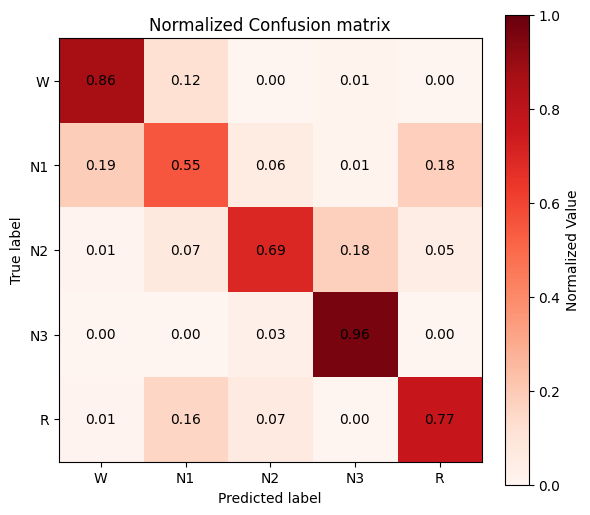

In [54]:
conf_mat = confusion_matrix(y_true, y_pred)
plot_normalized_confusion_matrix(conf_mat, classes_mapping);

What kind of mistakes does the ConvNet seem to make? Is there a class that's often mistaken for another one?

We can also visualize the predictions on a recording basis. This visualization is known as a "[hypnogram](https://en.wikipedia.org/wiki/Hypnogram)". A hypnogram shows the evolution of sleep stages across an overnight recording.

The ConcNet seems to be mistaking the stages W, N1 and R. We will try to see why by projecting them in the 2D ACP space

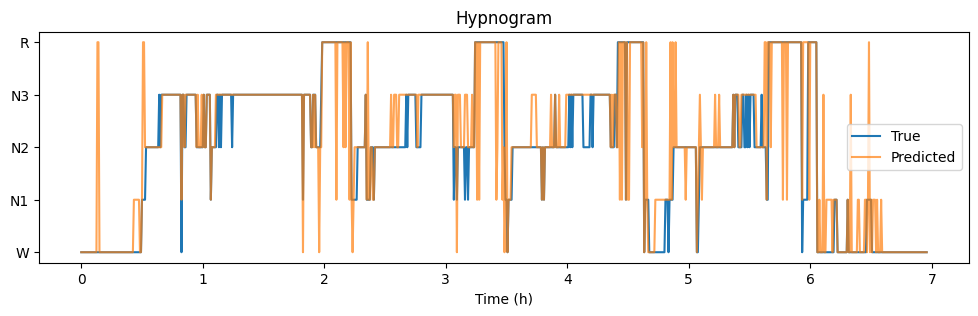

In [55]:
# Plot hypnogram for one recording

mask = rec_ids == 0  # pick a recording number

t = np.arange(len(y_true[mask])) * 30 / 3600

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(t, y_true[mask], label='True')
ax.plot(t, y_pred[mask], alpha=0.7, label='Predicted')
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels(['W', 'N1', 'N2', 'N3', 'R'])
ax.set_xlabel('Time (h)')
ax.set_title('Hypnogram')
ax.legend();

Do the predictions of the ConvNet follow the groundtruth hypnogram? Is there any structure in the way mistakes are made?

## Going further

You've now covered all the material for this tutorial!

To test what you have learned, we recommend you identify a few key elements in the pipeline shown above, and play with them to try to improve the performance of your ConvNet. Here are a few ideas to get you started:
- Increasing the training set size
- Improving the architecture (you can look at recent sleep staging literature, or follow your intuition!)
- Optimizing the training hyperparameters (learning rate, batch size, etc.)

Good luck! :)